In [526]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance
import joblib
from scipy.stats import wilcoxon
from tqdm import tqdm
from xgboost import XGBRegressor

# Assignment 1 - Part 1

## 1. Exploration

In [527]:
data = pd.read_parquet('training_data.parquet')

In [528]:
display(data)

,date,firm_id,macro1,macro2,price,firm1,firm2,firm3,ret
0,2020-01-01,0,Recovery,-0.226155,276.226209,0.061042,0.034084,-0.847778,0.005584
1,2020-01-01,1,Recovery,-0.226155,83.808180,-1.202923,-1.810058,0.346567,-0.022935
2,2020-01-01,2,Recovery,-0.226155,149.170163,-0.872318,-0.861621,-0.092319,-0.029843
3,2020-01-01,3,Recovery,-0.226155,48.770836,0.831588,-0.136184,-1.165729,-0.003266
4,2020-01-01,4,Recovery,-0.226155,109.207015,0.827317,-1.984357,-1.408475,0.035171
...,...,...,...,...,...,...,...,...,...
12095,2020-04-30,95,Expansion,-0.291960,243.270332,0.052227,-0.163971,-0.123048,-0.011068
12096,2020-04-30,96,Expansion,-0.291960,495.830892,0.087183,0.797017,0.137318,-0.032389
12097,2020-04-30,97,Expansion,-0.291960,112.382285,0.511944,0.890057,-0.182908,0.066233
12098,2020-04-30,98,Expansion,-0.291960,38.237366,-0.086010,-0.176002,0.127472,0.039939


In [529]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12100 entries, 0 to 12099
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     12100 non-null  datetime64[ns]
 1   firm_id  12100 non-null  int64         
 2   macro1   12100 non-null  object        
 3   macro2   12100 non-null  float64       
 4   price    12100 non-null  float64       
 5   firm1    12100 non-null  float64       
 6   firm2    12100 non-null  float64       
 7   firm3    12100 non-null  float64       
 8   ret      12100 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 945.3+ KB


In [530]:
data.describe()

,date,firm_id,macro2,price,firm1,firm2,firm3,ret
count,12100,12100.000000,12100.000000,12100.000000,12100.000000,12100.000000,12100.000000,12100.000000
mean,2020-03-01 00:00:00,49.500000,-0.582961,141.188960,0.024705,0.021550,0.009670,-0.001010
min,2020-01-01 00:00:00,0.000000,-2.986708,7.002039,-1.400862,-2.821420,-1.823757,-0.254047
25%,2020-01-31 00:00:00,24.750000,-1.201005,61.972243,-0.212695,-0.359549,-0.240290,-0.058832
50%,2020-03-01 00:00:00,49.500000,-0.616099,125.683412,0.019438,0.024645,0.006752,-0.006339
75%,2020-03-31 00:00:00,74.250000,0.008259,206.407505,0.253699,0.408466,0.253598,0.054219
max,2020-04-30 00:00:00,99.000000,1.831133,495.830892,2.316590,3.061011,2.623558,0.410168
std,NaN,28.867263,0.900100,93.012463,0.353883,0.576792,0.380795,0.082814


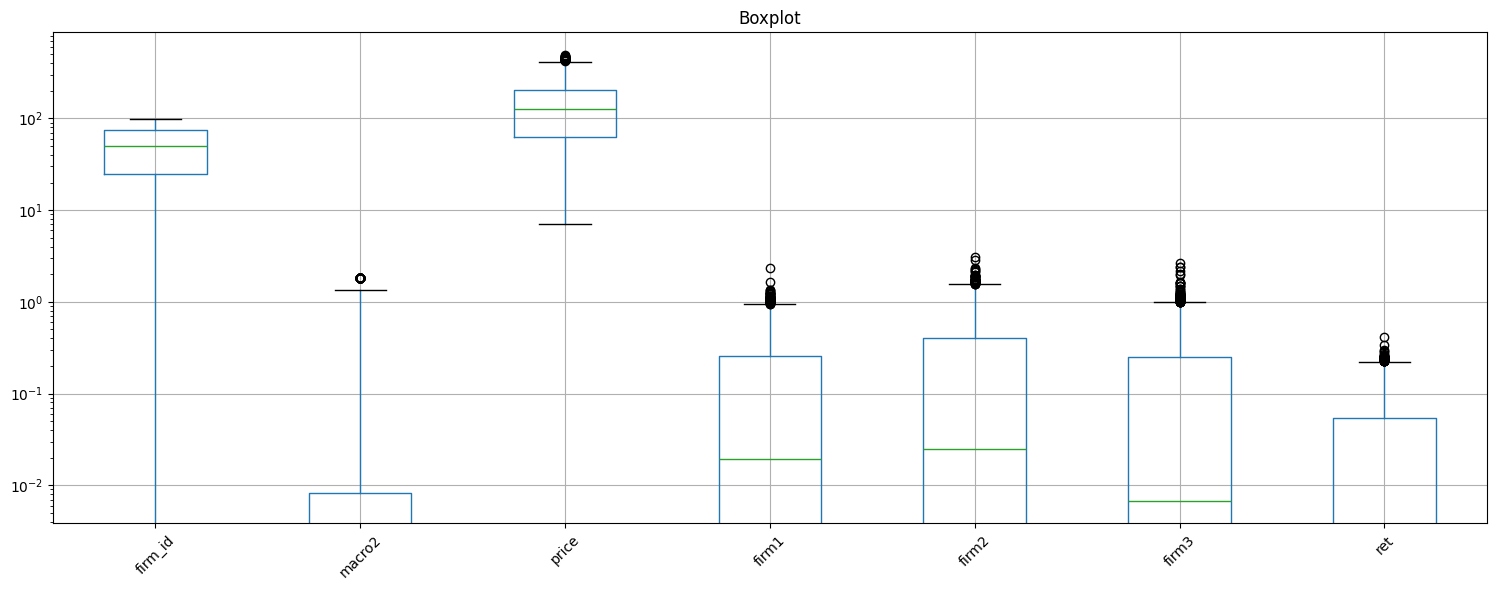

In [531]:
plt.figure(figsize=(15, 6))
data.select_dtypes(include='number').boxplot()
plt.title("Boxplot")
plt.xticks(rotation=45)
plt.tight_layout()
plt.yscale("log")
plt.show()

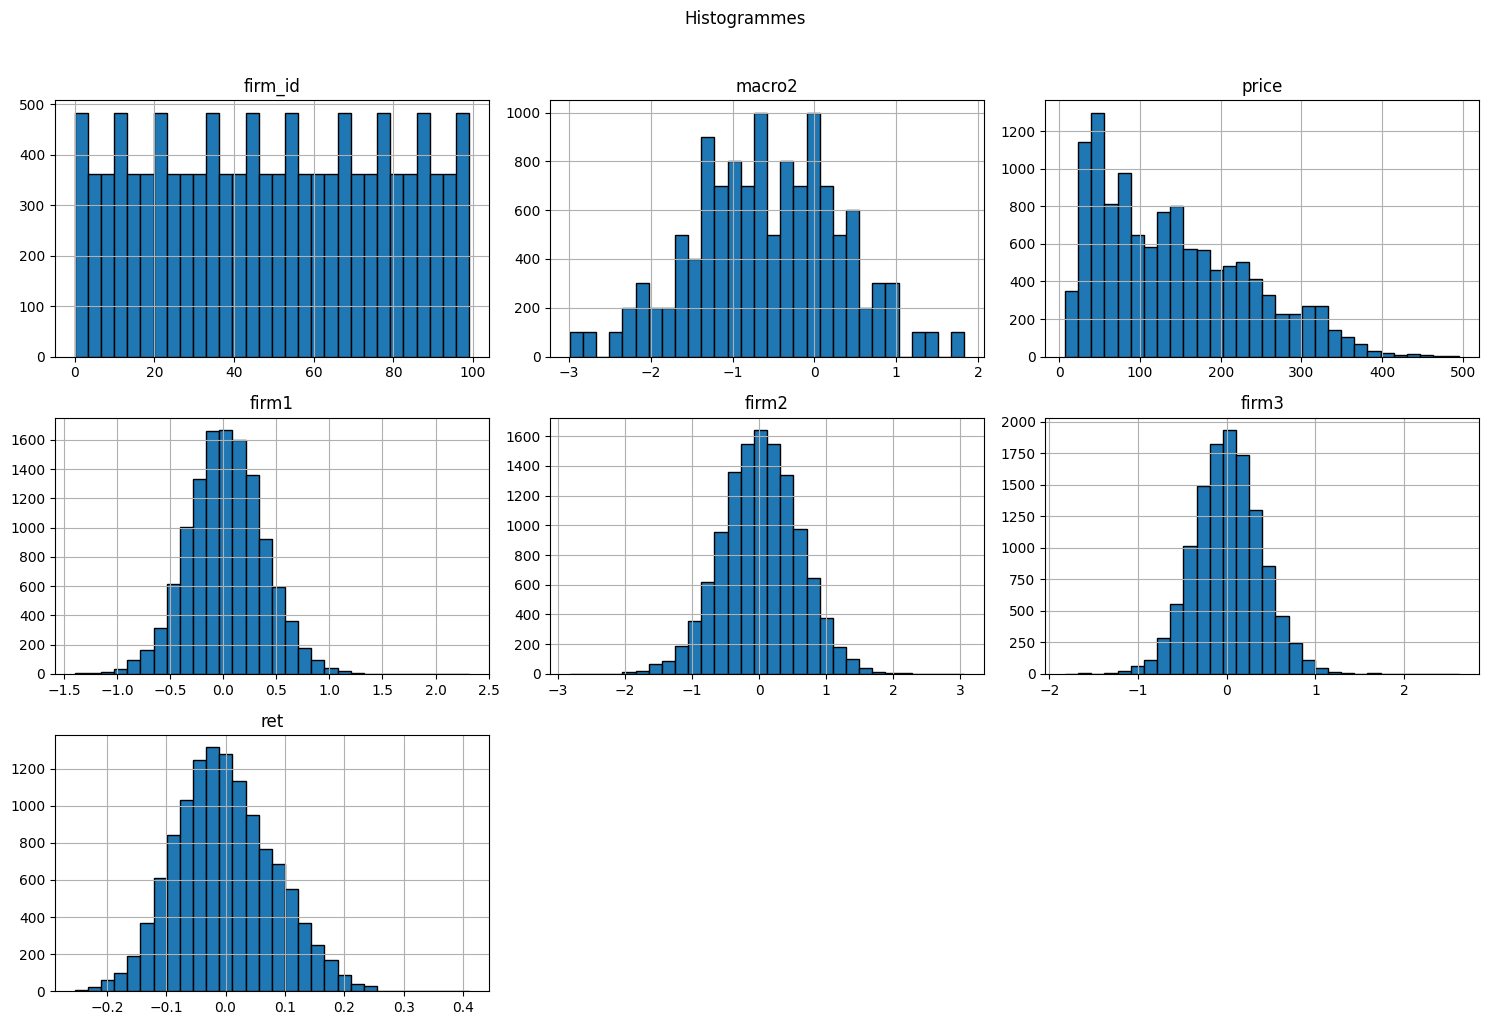

In [532]:
# Affichage des histogrammes
data.select_dtypes(include='number').hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Histogrammes", y=1.02)
plt.tight_layout()
plt.show()

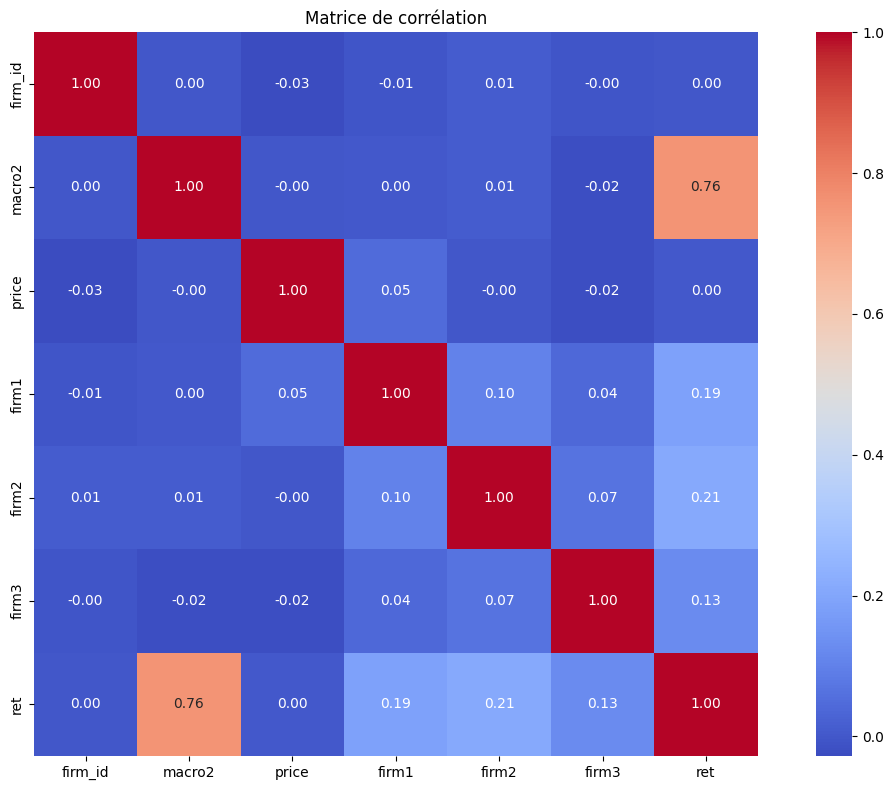

In [533]:
# Matrice de corrélation
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

In [534]:
print("Missing Values by columns :\n", data.isnull().sum())

Missing Values by columns :
 date       0
firm_id    0
macro1     0
macro2     0
price      0
firm1      0
firm2      0
firm3      0
ret        0
dtype: int64


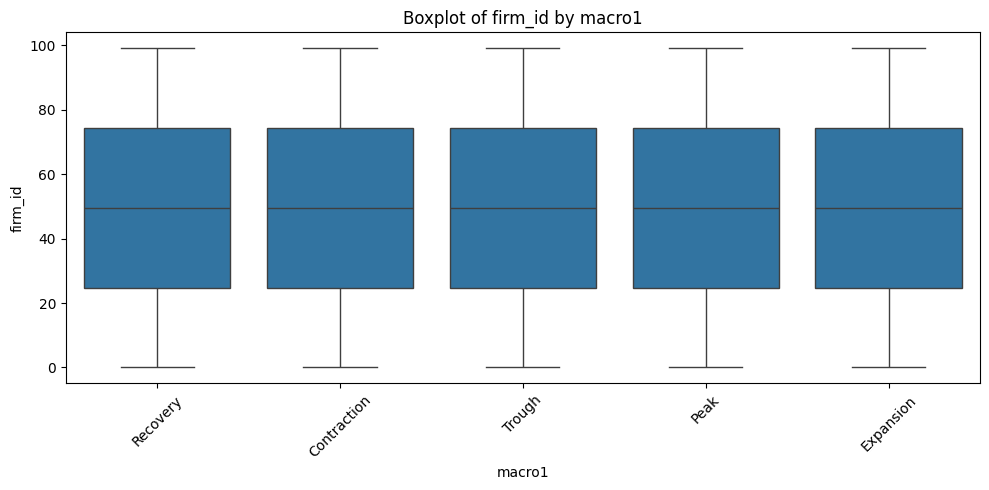

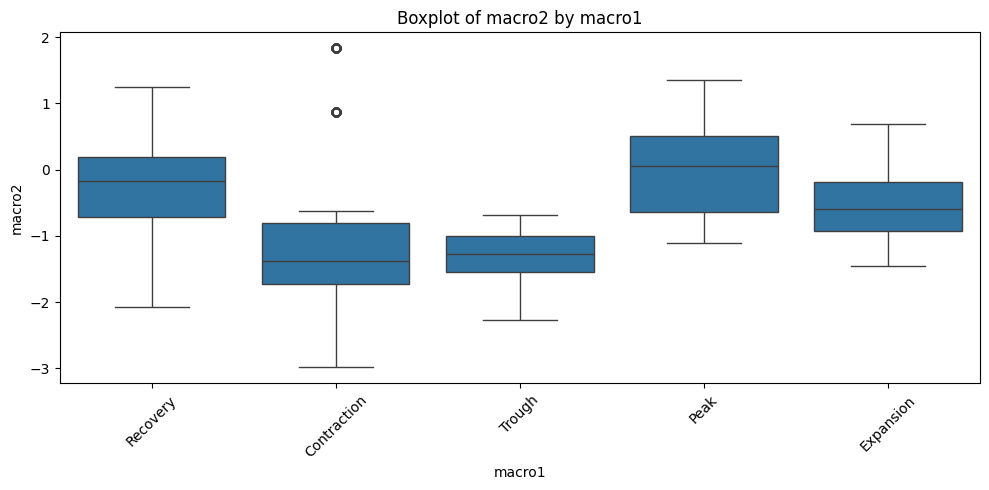

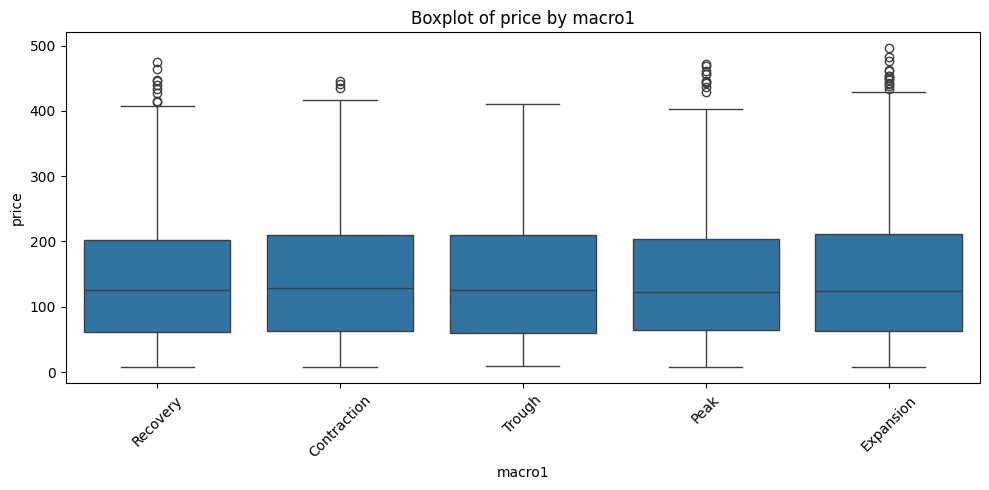

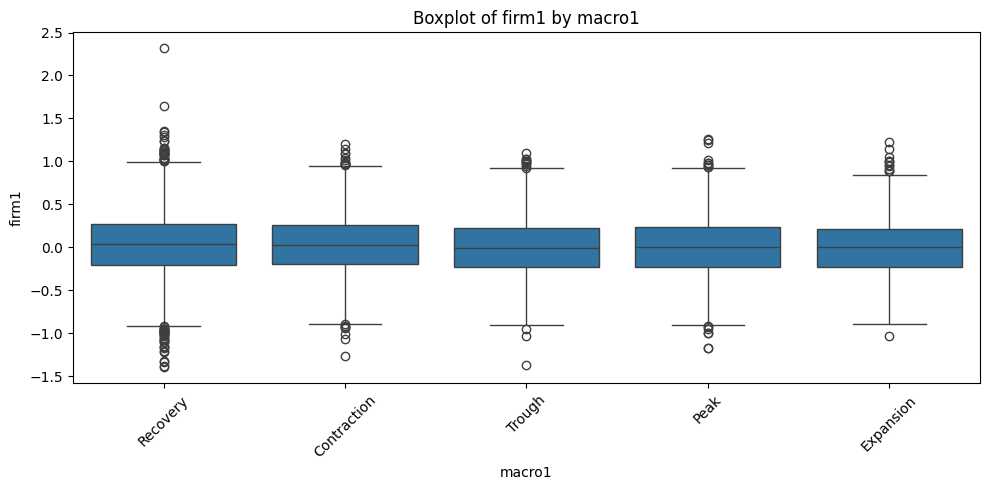

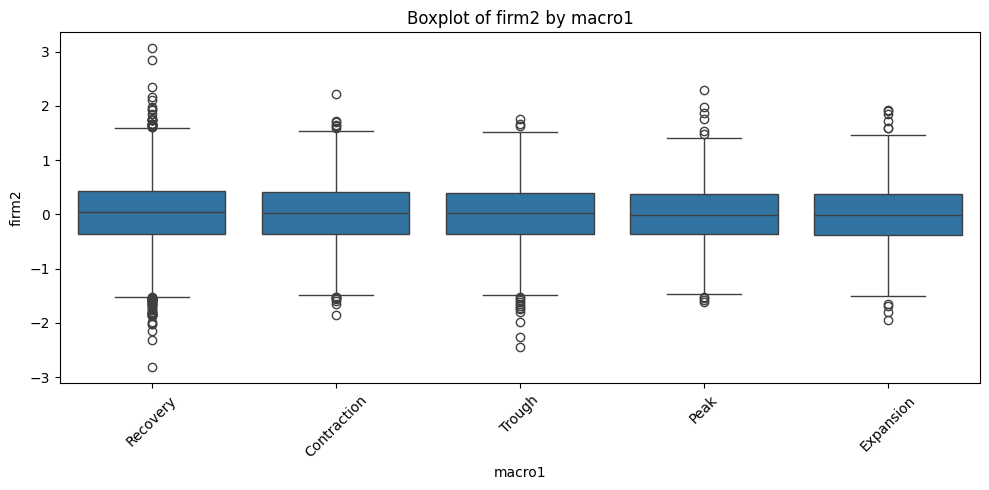

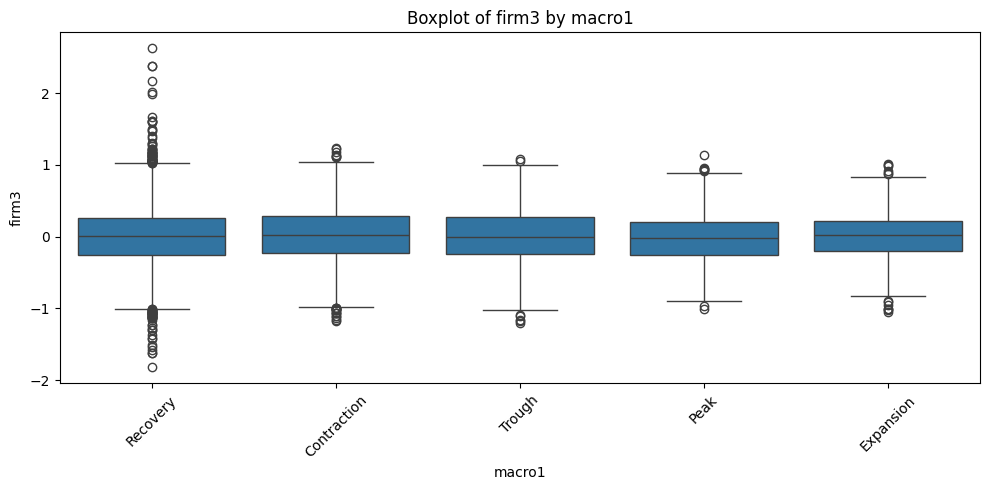

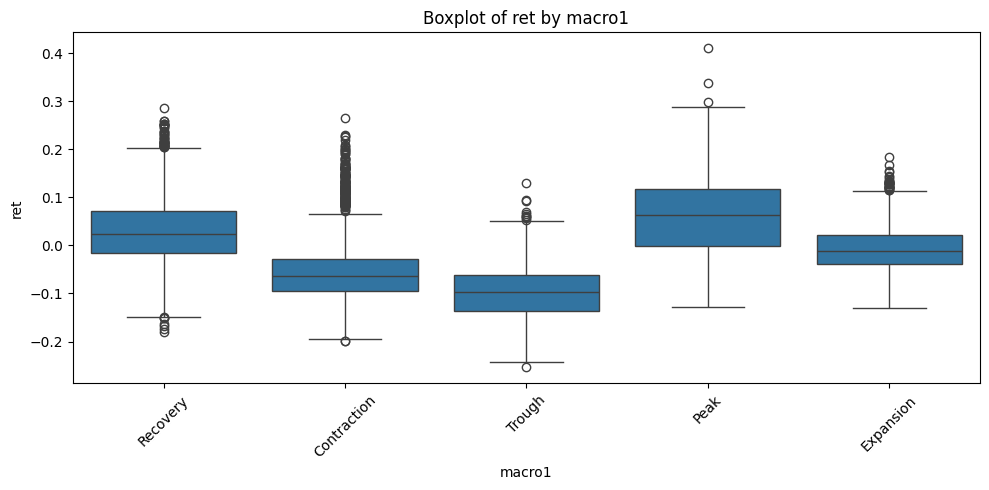

In [535]:
categorical_cols = data.select_dtypes(include='object').columns
numerical_cols = data.select_dtypes(include='number').columns

for cat in categorical_cols:
    for num in numerical_cols:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=data, x=cat, y=num)
        plt.title(f"Boxplot of {num} by {cat}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

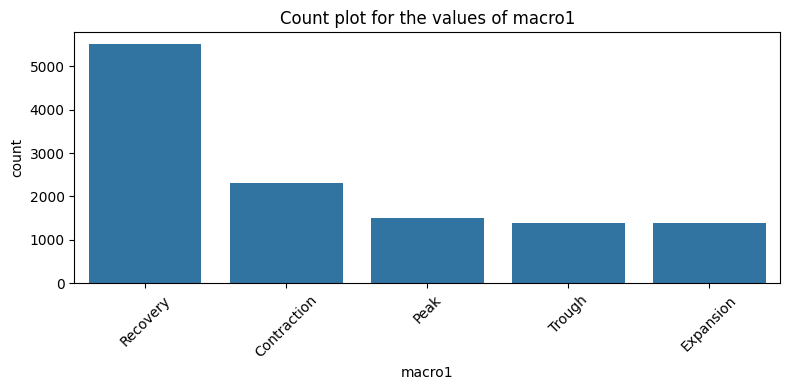

In [536]:
for cat in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=cat, order=data[cat].value_counts().index)
    plt.title(f"Count plot for the values of {cat}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

> Gros range de price \
> Aucune correlation entre les features \
> ~ Loi normale pour les carac numériques \
> Quelques outliers sur certaine valeurs numériques \
> Bcp de moment ou l'économie est dans uen phase de recovery \
> Bcp d'outlier quand l'économie est dans la phase de recovery \
> Aucune missing value 

# 2. Feature Engineering

In [537]:
data = data.sort_values(by='date')
# Ordinal encoding for macro1
macro1_order = ['Trough', 'Recovery', 'Expansion', 'Peak', 'Contraction']
encoder = OrdinalEncoder(categories=[macro1_order])
data['macro1_encoded'] = encoder.fit_transform(data[['macro1']])

# Return Lag
for lag in [1, 2, 3, 5]:
    data[f'ret_lag_{lag}'] = data.groupby('firm_id')['ret'].shift(lag)

# Rolling stats on Returns
window_sizes = [5, 10, 20]
for window in window_sizes:
    data[f'rolling_mean_ret_{window}'] = data.groupby('firm_id')['ret'].shift(1).rolling(window).mean().reset_index(0, drop=True)
    data[f'rolling_std_ret_{window}'] = data.groupby('firm_id')['ret'].shift(1).rolling(window).std().reset_index(0, drop=True)
    data[f'rel_volatility_{window}'] = data[f'rolling_std_ret_{window}'] / (data[f'rolling_mean_ret_{window}'].abs() + 1e-8)

# Momentum of price
for window in [5, 10, 20]:
    data[f'momentum_{window}'] = data.groupby('firm_id')['price'].transform(lambda x: x / x.shift(window) - 1)
    data['mean_reversion_signal'] = data['ret_lag_1'] * data['momentum_5']


# Ranks cross-sectionnal of firm-specific variables 
for col in ['firm1', 'firm2', 'firm3']:
    data[f'{col}_rank'] = data.groupby('date')[col].rank()

# firm × macro Interactions 
for col in ['firm1', 'firm2', 'firm3']:
    data[f'{col}_x_macro2'] = data[col] * data['macro2']

# Historical mean of returns by firms
firm_avg_ret = data.groupby('firm_id')['ret'].mean().rename('firm_avg_ret')
data = data.merge(firm_avg_ret, on='firm_id')

# Change of macroeconomic regime
data['macro1_change'] = data.groupby('firm_id')['macro1_encoded'].diff().fillna(0).ne(0).astype(int)

#interactions
data['firm1_over_firm2'] = data['firm1'] / (data['firm2'].abs() + 1e-8)
data['firm1_times_firm2'] = data['firm1'] * data['firm2']


# Calandar stuff
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['day_of_year'] = data['date'].dt.dayofyear
data['sin_day'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
data['cos_day'] = np.cos(2 * np.pi * data['day_of_year'] / 365)
data['sin_day_of_week'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['cos_day_of_week'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

data['price_inv'] = 1//data['price']
data['diff_price'] = data['price'] - data['price'].shift()

data['macro2_squared'] = np.power(data['macro2'],2)
data['macro2_cube'] = np.power(data['macro2'],3)
data['price_squared'] = np.power(data['price'],2)
data['price_cube'] = np.power(data['price'],3)

data.dropna(inplace=True)

In [538]:
data

,date,firm_id,macro1,macro2,price,firm1,firm2,firm3,ret,macro1_encoded,...,sin_day,cos_day,sin_day_of_week,cos_day_of_week,price_inv,diff_price,macro2_squared,macro2_cube,price_squared,price_cube
2000,2020-01-21,65,Recovery,-0.719389,41.488480,-0.124607,0.734833,0.598774,0.013519,1.0,...,0.353676,0.935368,0.781831,0.623490,0.0,-72.347689,0.517521,-0.372299,1721.293973,7.141387e+04
2001,2020-01-21,66,Recovery,-0.719389,185.870386,0.470322,0.845907,0.711581,0.072913,1.0,...,0.353676,0.935368,0.781831,0.623490,0.0,144.381906,0.517521,-0.372299,34547.800392,6.421413e+06
2002,2020-01-21,67,Recovery,-0.719389,183.124037,-0.368628,0.359114,0.096535,-0.006847,1.0,...,0.353676,0.935368,0.781831,0.623490,0.0,-2.746349,0.517521,-0.372299,33534.412927,6.140957e+06
2003,2020-01-21,68,Recovery,-0.719389,193.052204,0.940332,-0.017391,-0.056546,0.062822,1.0,...,0.353676,0.935368,0.781831,0.623490,0.0,9.928167,0.517521,-0.372299,37269.153469,7.194892e+06
2004,2020-01-21,73,Recovery,-0.719389,99.919069,0.243903,-0.013970,-0.265116,-0.045657,1.0,...,0.353676,0.935368,0.781831,0.623490,0.0,-93.133135,0.517521,-0.372299,9983.820350,9.975740e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12095,2020-04-30,27,Expansion,-0.291960,132.323633,-0.033495,0.007458,0.018415,0.017544,2.0,...,0.871706,-0.490029,0.433884,-0.900969,0.0,-106.261547,0.085241,-0.024887,17509.543850,2.316926e+06
12096,2020-04-30,26,Expansion,-0.291960,98.655451,0.179551,0.399636,-0.137979,-0.011814,2.0,...,0.871706,-0.490029,0.433884,-0.900969,0.0,-33.668182,0.085241,-0.024887,9732.898012,9.602034e+05
12097,2020-04-30,24,Expansion,-0.291960,250.036897,-0.110440,-0.141610,0.171370,-0.009360,2.0,...,0.871706,-0.490029,0.433884,-0.900969,0.0,151.381446,0.085241,-0.024887,62518.449861,1.563192e+07
12098,2020-04-30,35,Expansion,-0.291960,123.613652,-0.141108,0.613393,-0.041823,0.036609,2.0,...,0.871706,-0.490029,0.433884,-0.900969,0.0,-126.423245,0.085241,-0.024887,15280.334961,1.888858e+06


In [539]:
data.columns

Index(['date', 'firm_id', 'macro1', 'macro2', 'price', 'firm1', 'firm2',
       'firm3', 'ret', 'macro1_encoded', 'ret_lag_1', 'ret_lag_2', 'ret_lag_3',
       'ret_lag_5', 'rolling_mean_ret_5', 'rolling_std_ret_5',
       'rel_volatility_5', 'rolling_mean_ret_10', 'rolling_std_ret_10',
       'rel_volatility_10', 'rolling_mean_ret_20', 'rolling_std_ret_20',
       'rel_volatility_20', 'momentum_5', 'mean_reversion_signal',
       'momentum_10', 'momentum_20', 'firm1_rank', 'firm2_rank', 'firm3_rank',
       'firm1_x_macro2', 'firm2_x_macro2', 'firm3_x_macro2', 'firm_avg_ret',
       'macro1_change', 'firm1_over_firm2', 'firm1_times_firm2', 'day_of_week',
       'month', 'day_of_year', 'sin_day', 'cos_day', 'sin_day_of_week',
       'cos_day_of_week', 'price_inv', 'diff_price', 'macro2_squared',
       'macro2_cube', 'price_squared', 'price_cube'],
      dtype='object')

# 3. Train - Validation Split

In [540]:
data = data.sort_values('date')

unique_dates = data['date'].drop_duplicates().sort_values()
split_index = int(0.8 * len(unique_dates))
split_date = unique_dates.iloc[split_index]

train_data = data[data['date'] <= split_date]
val_data   = data[data['date'] > split_date]

# 4. Model 

In [541]:
feature_cols = ['firm_id', 'macro2', 'price', 'firm1', 'firm2',
       'firm3', 'macro1_encoded', 'macro2_squared','price_inv',
       'price_squared', 'price_cube', 'macro2_cube',
       'ret_lag_1', 'ret_lag_2', 'ret_lag_3','ret_lag_5', 
       'rolling_mean_ret_5', 'rolling_std_ret_5','diff_price',
       'rel_volatility_5', 'rolling_mean_ret_10', 'rolling_std_ret_10',
       'rel_volatility_10', 'rolling_mean_ret_20', 'rolling_std_ret_20',
       'rel_volatility_20', 'momentum_5', 'momentum_10', 'momentum_20',
       'firm1_rank', 'firm2_rank', 'firm3_rank', 'firm1_x_macro2',
       'firm2_x_macro2', 'firm3_x_macro2', 'macro1_change',
       'firm_avg_ret', 'cos_day_of_week','sin_day_of_week' ,
       'month', 'sin_day', 'cos_day', "mean_reversion_signal",
       'firm1_over_firm2','firm1_times_firm2']

# Données d'entraînement
X_train = train_data[feature_cols]
y_train = train_data['ret']

# Données de validation
X_val = val_data[feature_cols]
y_val = val_data['ret']

In [542]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),
    ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.7))
])

pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,Lasso(alpha=0.001)
,threshold,None
,prefit,False
,norm_order,1


In [543]:
y_pred = pipeline.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.6f}")
print(f"Validation R²:  {r2:.5f}")

Validation RMSE: 0.034798
Validation R²:  0.79371


# 5. Hyperparameters Optimisation

In [544]:
tscv = TimeSeriesSplit(n_splits=5)
scorer = make_scorer(r2_score, greater_is_better=True)

In [545]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(max_iter=5000))
])

param_grid = {
    'elasticnet__alpha': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10],
    'elasticnet__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9]
}

grid = GridSearchCV(pipe, param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
grid.fit(X_train, y_train)

/Users/Mel/Desktop/Berkeley/230P/230P/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.279e-03, tolerance: 7.362e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mel/Desktop/Berkeley/230P/230P/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.905e-03, tolerance: 7.362e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mel/Desktop/Berkeley/230P/230P/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

,estimator,Pipeline(step..._iter=5000))])
,param_grid,"{'elasticnet__alpha': [1e-05, 0.0001, ...], 'elasticnet__l1_ratio': [0.1, 0.2, ...]}"
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [546]:
print("Best Parameters:", grid.best_params_)
print("Best CV MSE:", grid.best_score_)

best_model = grid.best_estimator_

y_pred_val = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MSE: {val_rmse:.6f}")

Best Parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.5}
Best CV MSE: 0.5616430552544064
Validation MSE: 0.034658


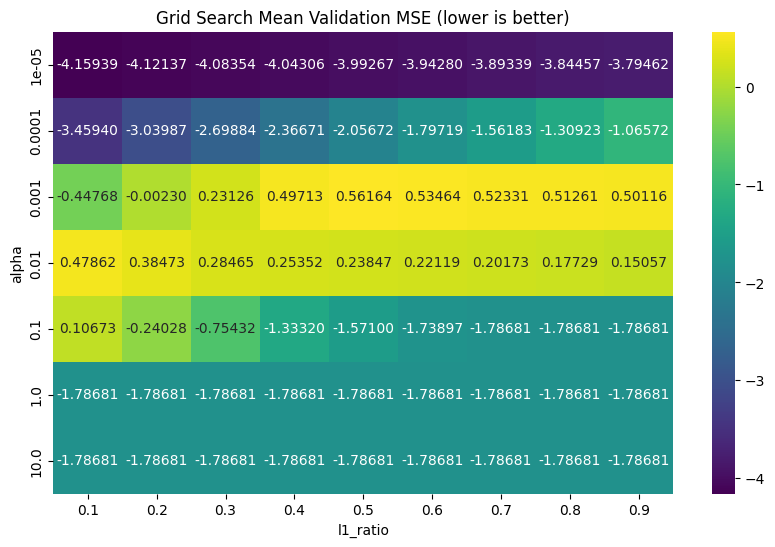

In [547]:
# Récupération des résultats du GridSearch
results = pd.DataFrame(grid.cv_results_)

# Pivot de la grille pour avoir une matrice alpha x l1_ratio
pivot_table = results.pivot_table(
    index='param_elasticnet__alpha',
    columns='param_elasticnet__l1_ratio',
    values='mean_test_score'
)

# On prend l'opposé des scores car MSE est négatif dans GridSearch (car on maximise par défaut)
pivot_table = pivot_table

# Affichage de la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".5f", cmap="viridis")
plt.title("Grid Search Mean Validation MSE (lower is better)")
plt.xlabel("l1_ratio")
plt.ylabel("alpha")
plt.show()

## 6. Saving the best Model

In [548]:
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),
    ('elasticnet', ElasticNet(alpha = grid.best_params_['elasticnet__alpha'], l1_ratio=grid.best_params_['elasticnet__l1_ratio']))
])

best_model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,Lasso(alpha=0.001)
,threshold,None
,prefit,False
,norm_order,1


In [549]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [550]:
y_pred = best_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.6f}")
print(f"Validation R²:  {r2:.5f}")

Validation RMSE: 0.034626
Validation R²:  0.79574


## Part 2: Feature Importance

In [551]:
result = permutation_importance(
    best_model, 
    X_val, y_val,
    n_repeats=150,              
    scoring='r2', 
    random_state=42,
    n_jobs=-1
)

In [552]:
importances = result.importances_mean
std = result.importances_std
feature_names = X_val.columns

In [553]:
indices = np.argsort(importances)[::-1]

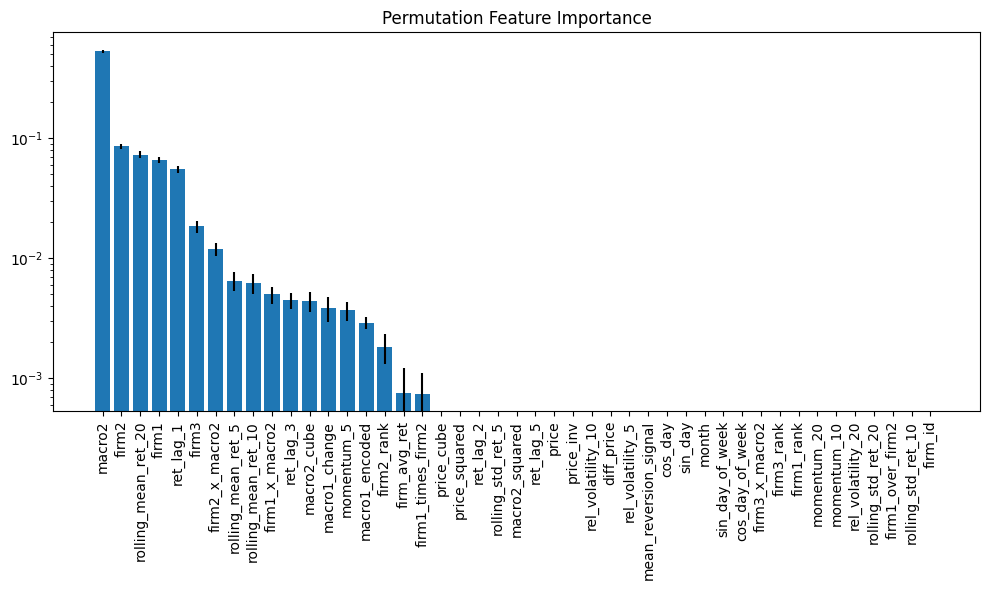

In [554]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], yerr=std[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Permutation Feature Importance")
plt.yscale('log')
plt.tight_layout()
plt.show()

In [555]:
# We use a non parametric test to get the p-values of the feature importance. The wilcoxon test is here adapted 

/Users/Mel/Desktop/Berkeley/230P/230P/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


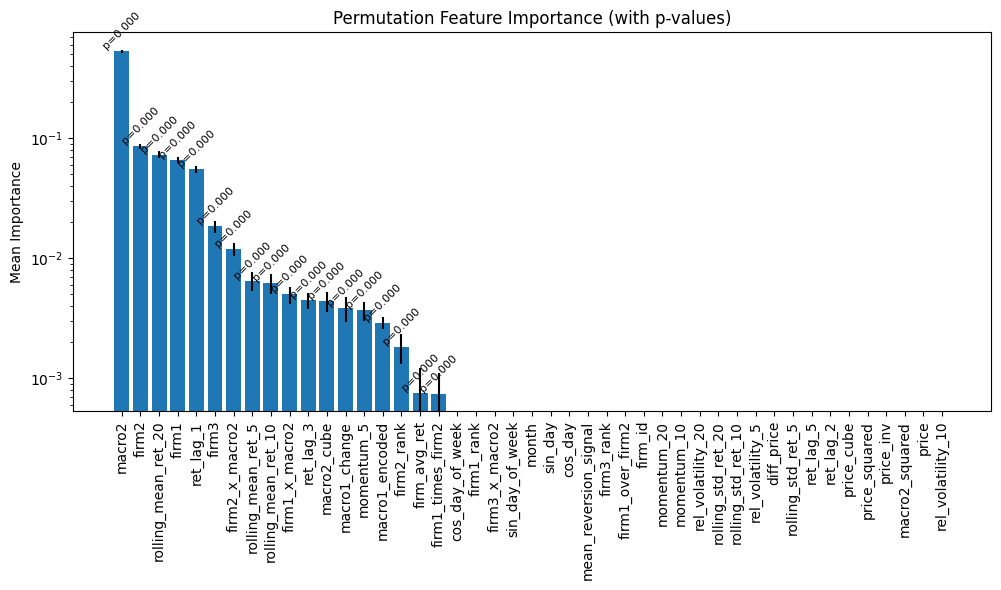

In [556]:
p_values = []
mean_importances = []
std_importances = []
features = X_val.columns

for i, feature in enumerate(features):
    scores = result.importances[i]
    stat, p = wilcoxon(scores - 0)
    p_values.append(p)
    mean_importances.append(scores.mean())
    std_importances.append(scores.std())

df_importance = pd.DataFrame({
    'Feature': features,
    'Mean Importance': mean_importances,
    'Std Importance': std_importances,
    'p-value': p_values
}).sort_values('Mean Importance', ascending=False)

# Affichage
plt.figure(figsize=(10, 6))
bars = plt.bar(df_importance['Feature'], df_importance['Mean Importance'], yerr=df_importance['Std Importance'])
plt.xticks(rotation=90)
plt.title("Permutation Feature Importance (with p-values)")
plt.ylabel("Mean Importance")

# Annotation des p-values
for bar, pval in zip(bars, df_importance['p-value']):
    if bar.get_height() > 1e-4:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"p={pval:.3f}", 
                ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.yscale('log')
plt.show()


# Asignment 2

## Part 1. Fit a tree

In [557]:
from xgboost import XGBRegressor

# Pipeline avec sélection de features (optionnelle ici avec Lasso par exemple)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),  # facultatif avec XGBoost
    ('xgb', XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,Lasso(alpha=0.001)
,threshold,None
,prefit,False
,norm_order,1


In [558]:
y_pred = pipeline.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.6f}")
print(f"Validation R²:  {r2:.5f}")

Validation RMSE: 0.039634
Validation R²:  0.73238


## Part 2. Select the best hyper-parameters

In [559]:
param_grid = {
    'xgb__n_estimators': [50, 100, 150, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.5],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

In [560]:
print("Best Parameters:", grid.best_params_)
print("Best CV R2:", grid.best_score_)

best_model = grid.best_estimator_

y_pred_val = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MSE: {val_rmse:.6f}")

Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 150}
Best CV R2: 0.6476453789782312
Validation MSE: 0.038956


In [561]:
best_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),
    ('xgb', XGBRegressor(
    n_estimators=grid.best_params_['xgb__n_estimators'],
    max_depth=grid.best_params_['xgb__max_depth'],
    learning_rate=grid.best_params_['xgb__learning_rate'],
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
    ))
])

best_tree.fit(X_train, y_train)

,steps,"[('scaler', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,Lasso(alpha=0.001)
,threshold,None
,prefit,False
,norm_order,1


In [562]:
y_pred = best_tree.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.6f}")
print(f"Validation R²:  {r2:.5f}")

Validation RMSE: 0.038956
Validation R²:  0.74145


In [563]:
joblib.dump(best_tree, 'best_tree.pkl')

['best_tree.pkl']

## Part3. Feature importance

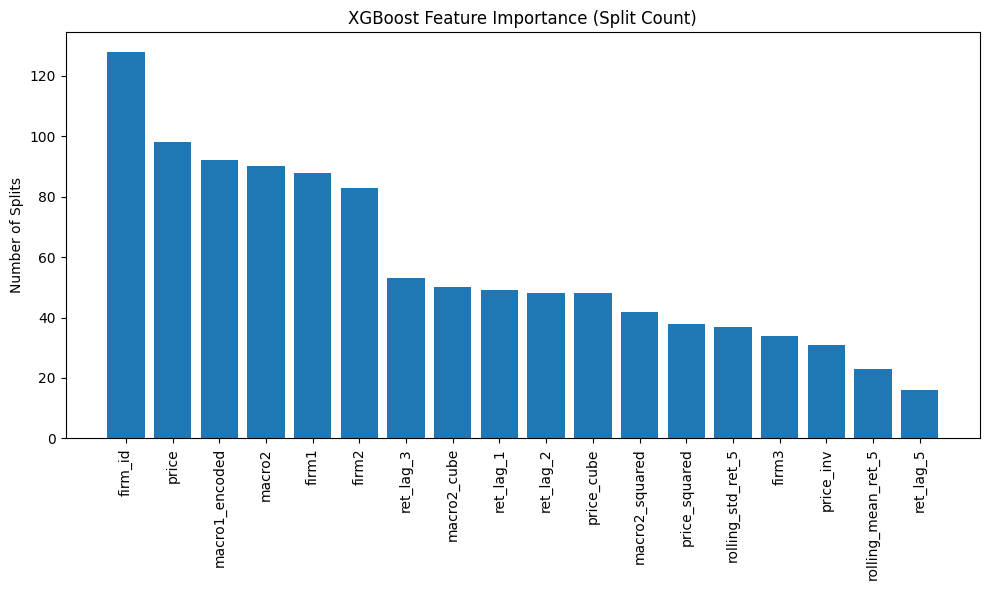

In [564]:
xgb_model = best_model.named_steps['xgb']

# Obtenir l’importance par nombre de splits ("weight")
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='weight')

# Mettre sous forme de DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Split Count': list(importance_dict.values())
})

# Nettoyage : remettre les noms originaux si besoin (si tu as un scaler ou autre)
# Exemple si tu veux mapper f0 → ton vrai nom de colonne :
if hasattr(X_train, 'columns'):
    feature_map = {f"f{i}": name for i, name in enumerate(X_train.columns)}
    importance_df['Feature'] = importance_df['Feature'].map(feature_map)

# Tri décroissant
importance_df = importance_df.sort_values('Split Count', ascending=False)

# Affichage
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Split Count'])
plt.xticks(rotation=90)
plt.title("XGBoost Feature Importance (Split Count)")
plt.ylabel("Number of Splits")
plt.tight_layout()
plt.show()

In [565]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tqdm import tqdm
import numpy as np
import pandas as pd

# Paramètres
n_bootstrap = 50
feature_names = X_train.columns  # Train set respectueux de la structure temporelle

# Initialisation des scores bootstrapés
split_counts = {name: [] for name in feature_names}

# Boucle bootstrap
for _ in tqdm(range(n_bootstrap), desc="Bootstrapping (split count)"):
    # Échantillonnage avec remise sur le train set
    X_sample, y_sample = resample(X_train, y_train)

    # Standardisation (si nécessaire)
    scaler = StandardScaler()
    X_sample_scaled = pd.DataFrame(scaler.fit_transform(X_sample), columns=X_sample.columns)

    # Entraînement du modèle XGBoost
    model = XGBRegressor(
        n_estimators=200,
        max_depth=grid.best_params_['xgb__max_depth'],
        learning_rate=grid.best_params_['xgb__learning_rate'],
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_sample_scaled, y_sample)

    # Récupération des importances par splits (weight)
    booster = model.get_booster()
    split_dict = booster.get_score(importance_type='weight')
    # Mapping f0 → vrai nom
    feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

    # Compteur pour ce bootstrap
    current_counts = {name: 0 for name in feature_names}
    for f_key, count in split_dict.items():
        if f_key in feature_map:
            current_counts[feature_map[f_key]] = count

    # Stockage
    for name in feature_names:
        split_counts[name].append(split_dict[name] if name in split_dict.keys() else 0)

# Résumé statistique + p-values
df_split_bootstrap = pd.DataFrame({
    'Feature': feature_names,
    'Mean Split Count': [np.mean(split_counts[name]) for name in feature_names],
    'Std Split Count': [np.std(split_counts[name]) for name in feature_names],
    'p-value': [np.mean(np.array(split_counts[name]) <= 0) for name in feature_names]
}).sort_values('Mean Split Count', ascending=False).reset_index(drop=True)

# Affichage
print(df_split_bootstrap)


Bootstrapping (split count): 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]

                  Feature  Mean Split Count  Std Split Count  p-value
0                  macro2            103.56         7.828563     0.00
1               ret_lag_1             77.28         6.349929     0.00
2                   firm2             69.06         9.296042     0.00
3          macro1_encoded             66.76         5.530136     0.00
4                   firm1             57.02         7.179109     0.00
5                   firm3             55.94         6.351094     0.00
6              firm2_rank             51.00         6.907966     0.00
7          firm2_x_macro2             50.78         6.966463     0.00
8                 sin_day             45.66         7.452812     0.00
9              momentum_5             44.32         5.791166     0.00
10    rolling_mean_ret_20             37.58         7.851344     0.00
11         firm1_x_macro2             37.42         6.594210     0.00
12     rolling_std_ret_20             36.22         6.271491     0.00
13              ret_

In [566]:
df_split_bootstrap

,Feature,Mean Split Count,Std Split Count,p-value
0,macro2,103.56,7.828563,0.00
1,ret_lag_1,77.28,6.349929,0.00
2,firm2,69.06,9.296042,0.00
3,macro1_encoded,66.76,5.530136,0.00
4,firm1,57.02,7.179109,0.00
5,firm3,55.94,6.351094,0.00
6,firm2_rank,51.00,6.907966,0.00
7,firm2_x_macro2,50.78,6.966463,0.00
8,sin_day,45.66,7.452812,0.00
9,momentum_5,44.32,5.791166,0.00


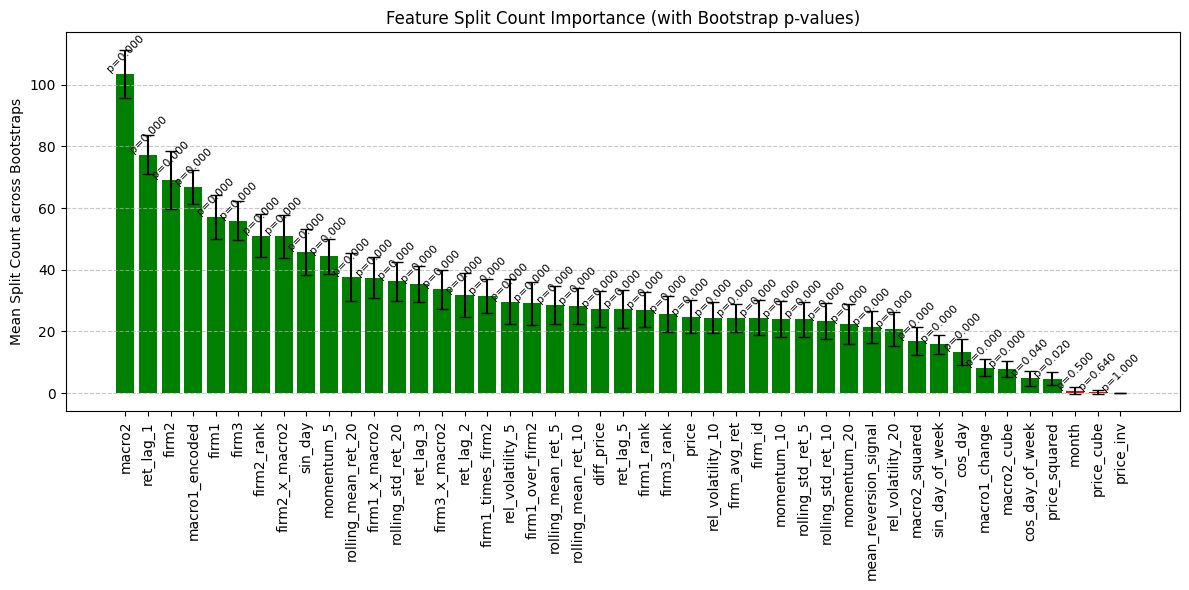

In [567]:

# Paramètres
significance_threshold = 0.05

# Tri du DataFrame
df_plot = df_split_bootstrap.sort_values("Mean Split Count", ascending=False).reset_index(drop=True)

# Couleurs : rouge si non significatif
colors = ['red' if p > significance_threshold else 'green' for p in df_plot['p-value']]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(df_plot['Feature'], df_plot['Mean Split Count'], 
               yerr=df_plot['Std Split Count'], color=colors, capsize=4)

# Annotation des p-values
for bar, pval in zip(bars, df_plot['p-value']):
    if not np.isnan(pval):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f"p={pval:.3f}", ha='center', va='bottom', fontsize=8, rotation=45)

# Stylisation
plt.xticks(rotation=90)
plt.title("Feature Split Count Importance (with Bootstrap p-values)")
plt.ylabel("Mean Split Count across Bootstraps")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
